In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import collections


In [3]:
# Load ECG datasets from provided paths
mitbih_train = pd.read_csv(r"C:\Users\ADMIN\Documents\Document\USTH\B3\machine learning in medicine\ecg data\mitbih_train.csv", header=None)
mitbih_test = pd.read_csv(r"C:\Users\ADMIN\Documents\Document\USTH\B3\machine learning in medicine\ecg data\mitbih_train.csv", header=None)
ptbdb_abnormal = pd.read_csv(r"C:\Users\ADMIN\Documents\Document\USTH\B3\machine learning in medicine\ecg data\mitbih_train.csv", header=None)
ptbdb_normal = pd.read_csv(r"C:\Users\ADMIN\Documents\Document\USTH\B3\machine learning in medicine\ecg data\ptbdb_normal.csv", header=None)


In [5]:
# Combine PTBDB datasets (0 = normal, 1 = abnormal)
ptbdb_combined = pd.concat([ptbdb_normal, ptbdb_abnormal])

In [6]:
# Prepare features and labels
X_mitbih_train = mitbih_train.iloc[:, :-1].values
y_mitbih_train = mitbih_train.iloc[:, -1].values
X_mitbih_test = mitbih_test.iloc[:, :-1].values
y_mitbih_test = mitbih_test.iloc[:, -1].values
X_ptbdb = ptbdb_combined.iloc[:, :-1].values
y_ptbdb = ptbdb_combined.iloc[:, -1].values


In [7]:
# Normalize data
scaler = StandardScaler()
X_mitbih_train = scaler.fit_transform(X_mitbih_train)
X_mitbih_test = scaler.transform(X_mitbih_test)
X_ptbdb = scaler.fit_transform(X_ptbdb)

In [8]:
# Reshape for CNN input
X_mitbih_train = X_mitbih_train.reshape((*X_mitbih_train.shape, 1))
X_mitbih_test = X_mitbih_test.reshape((*X_mitbih_test.shape, 1))
X_ptbdb = X_ptbdb.reshape((*X_ptbdb.shape, 1))

In [9]:
# Split PTBDB data
X_ptb_train, X_ptb_test, y_ptb_train, y_ptb_test = train_test_split(
    X_ptbdb, y_ptbdb, test_size=0.2, random_state=42, stratify=y_ptbdb
)

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(128, 5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(256, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])
    
    loss_func = 'sparse_categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy'
    model.compile(optimizer=Adam(0.001), loss=loss_func, metrics=['accuracy'])
    return model

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Normalized Confusion Matrix: {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [13]:
# Calculate class weights for MIT-BIH
class_weights = compute_class_weight('balanced', classes=np.unique(y_mitbih_train), y=y_mitbih_train)
class_weights = dict(enumerate(class_weights))

# MIT-BIH model training
mitbih_model = build_cnn_model((187, 1), 5)
mitbih_history = mitbih_model.fit(
    X_mitbih_train, y_mitbih_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_mitbih_test, y_mitbih_test),
    class_weight=class_weights
)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.5602 - loss: 1.3705 - val_accuracy: 0.8099 - val_loss: 0.6392
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.7311 - loss: 0.6197 - val_accuracy: 0.8273 - val_loss: 0.7251
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.8037 - loss: 0.4963 - val_accuracy: 0.8722 - val_loss: 0.4309
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.8388 - loss: 0.3725 - val_accuracy: 0.8501 - val_loss: 0.4482
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.8683 - loss: 0.3113 - val_accuracy: 0.9252 - val_loss: 0.2857
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.8791 - loss: 0.3020 - val_accuracy: 0.9171 - val_loss: 0.2609
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.8869 - loss: 0.2912 - val_accuracy: 0.9400 - val_loss: 0.2189
Epoch 8/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.8980 -

In [14]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(128, 5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(256, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        # Fixed output layer for binary classification
        Dense(1 if num_classes == 2 else num_classes, 
              activation='sigmoid' if num_classes == 2 else 'softmax')
    ])
    
    # Updated loss function handling
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
        
    model.compile(optimizer=Adam(0.001), loss=loss, metrics=['accuracy'])
    return model

# PTBDB model setup and training (corrected)
ptbdb_model = build_cnn_model((187, 1), 2)

ptbdb_history = ptbdb_model.fit(
    X_ptb_train, y_ptb_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_ptb_test, y_ptb_test)  # Now using original binary labels
)

Epoch 1/20
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.6680 - loss: -59281228.0000 - val_accuracy: 0.8045 - val_loss: -1349197312.0000
Epoch 2/20
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.6677 - loss: -3305016576.0000 - val_accuracy: 0.7921 - val_loss: -12938305536.0000
Epoch 3/20
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.6695 - loss: -22204682240.0000 - val_accuracy: 0.7869 - val_loss: -52886884352.0000
Epoch 4/20
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.6755 - loss: -71700512768.0000 - val_accuracy: 0.7257 - val_loss: -156079816704.0000
Epoch 5/20
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.6783 - loss: -166123552768.0000 - val_accuracy: 0.7697 - val_loss: -320107118592.0000
Epoch 6/20
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.6821 - loss: -328896053248.0000 - val_accuracy: 0.6955 - val_loss: -596323860480.0000
Epoch 7/20
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.6769 -

In [11]:
# Visualization function
def plot_training_results(history, title):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{title} Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{title} Accuracy')
    
    plt.tight_layout()
    plt.show()


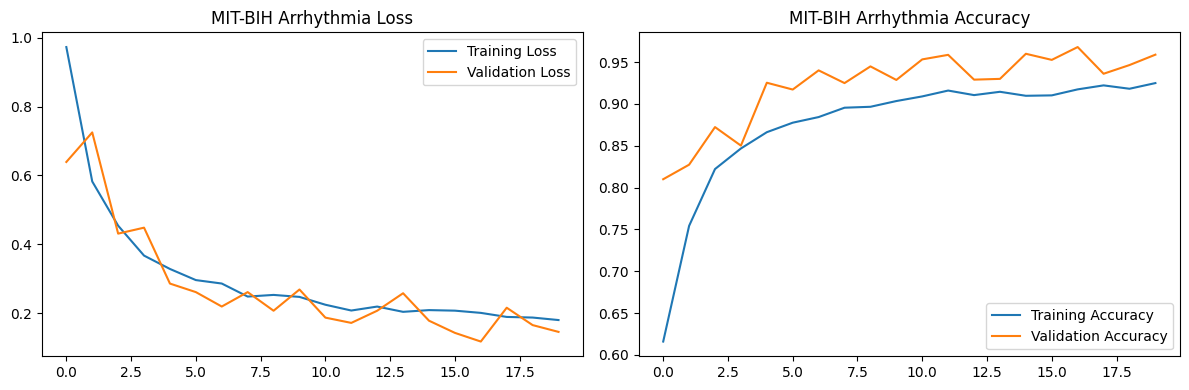

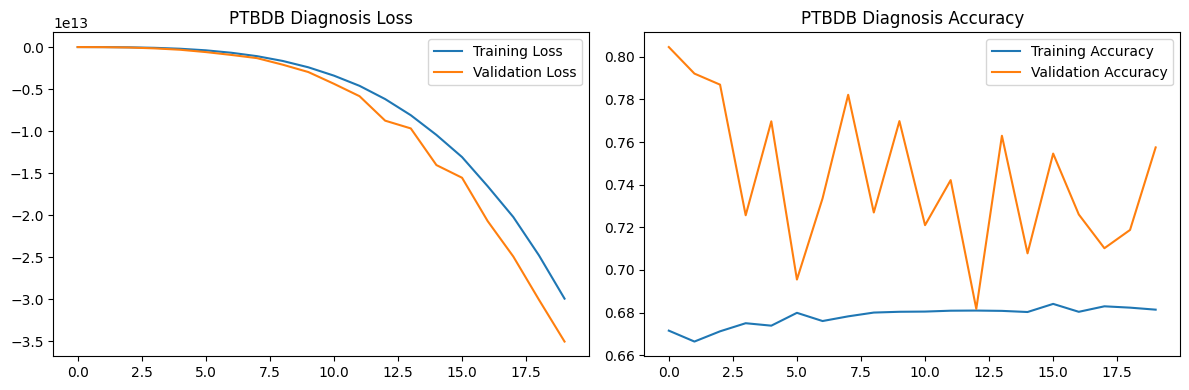

In [15]:
plot_training_results(mitbih_history, "MIT-BIH Arrhythmia")
plot_training_results(ptbdb_history, "PTBDB Diagnosis")

2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step

MIT-BIH Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     72471
         1.0       0.36      0.98      0.52      2223
         2.0       0.92      0.96      0.94      5788
         3.0       0.42      0.94      0.58       641
         4.0       0.99      0.99      0.99      6431

    accuracy                           0.94     87554
   macro avg       0.74      0.96      0.80     87554
weighted avg       0.97      0.94      0.95     87554



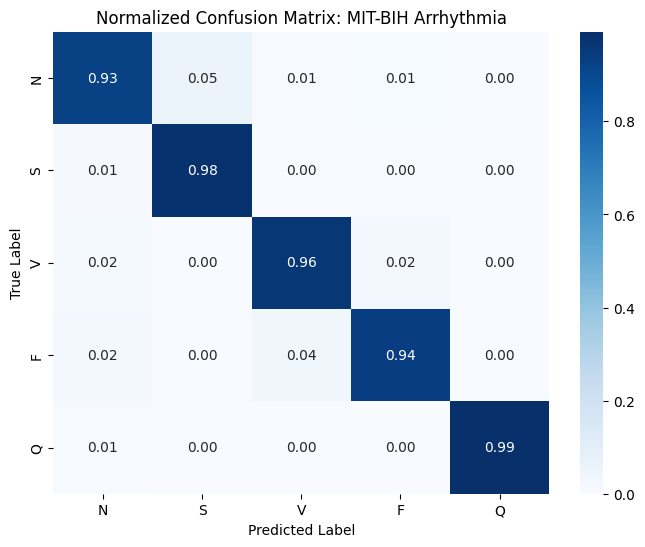

In [ ]:
# MIT-BIH Evaluation
y_pred_mitbih = np.argmax(mitbih_model.predict(X_mitbih_test), axis=1)
print("\nMIT-BIH Classification Report:")
print(classification_report(y_mitbih_test, y_pred_mitbih))
plot_confusion_matrix(y_mitbih_test, y_pred_mitbih,
                     classes=['N', 'S', 'V', 'F', 'Q'],
                     title="MIT-BIH Arrhythmia")

573/573 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

PTBDB Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94     15303
         1.0       0.03      0.31      0.06       445
         2.0       0.00      0.00      0.00      1158
         3.0       0.00      0.00      0.00       128
         4.0       0.00      0.00      0.00      1286

    accuracy                           0.76     18320
   macro avg       0.20      0.24      0.20     18320
weighted avg       0.81      0.76      0.79     18320



c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

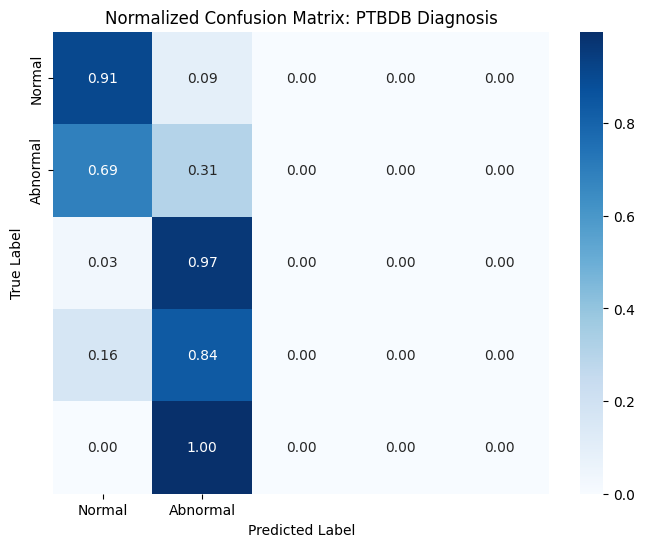

In [34]:
# PTBDB Evaluation
y_pred_ptbdb = (ptbdb_model.predict(X_ptb_test) > 0.5).astype(int).flatten()
print("\nPTBDB Classification Report:")
print(classification_report(y_ptb_test, y_pred_ptbdb))
plot_confusion_matrix(y_ptb_test, y_pred_ptbdb,
                     classes=['Normal', 'Abnormal'],
                     title="PTBDB Diagnosis")

In [37]:
# Keep existing prediction examples
print("\nMIT-BIH Predictions (First 10 samples):")
mitbih_preds = np.argmax(mitbih_model.predict(X_mitbih_test[:10]), axis=1)
print(f"Actual:    {y_mitbih_test[:10]}")
print(f"Predicted: {mitbih_preds}")


MIT-BIH Predictions (First 10 samples):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted: [0 0 0 0 0 0 0 0 0 0]


In [ ]:
print("\nPTBDB Predictions (First 10 samples):")
ptbdb_preds = (ptbdb_model.predict(X_ptb_test[:10]) > 0.5).astype(int).flatten()
print(f"Actual:    {y_ptb_test[:10]}")
print(f"Predicted: {ptbdb_preds}")


PTBDB Predictions (First 10 samples):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Actual:    [0. 0. 0. 0. 0. 4. 0. 0. 0. 0.]
Predicted: [0 0 1 0 1 1 0 0 0 0]
